# Image Processing SS 20 - Assignment - 02

### Deadline is 6.5.2020 at 11:55am

Please solve the assignments together with a partner.
I will run every notebook. Make sure the code runs through. Select `Kernel` -> `Restart & Run All` to test it.


# Exercise 1 - 10 Points

Implement affine transformation with [bicubic interpolation](https://en.wikipedia.org/wiki/Bicubic_interpolation).
Implement the functions `affine_transformation` and `bicubic_interpolation`. Apply some affine transformation of your choice and smooth the output using your bicubic interpolation.

In [2]:
# display the plots inside the notebook
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (12, 12)   # This makes the plot bigger

The [skimage](http://scikit-image.org/) library comes with multiple useful test images.  Let's start with an image of an astronaut. 

In [4]:
from skimage.data import astronaut
from skimage.color import rgb2gray

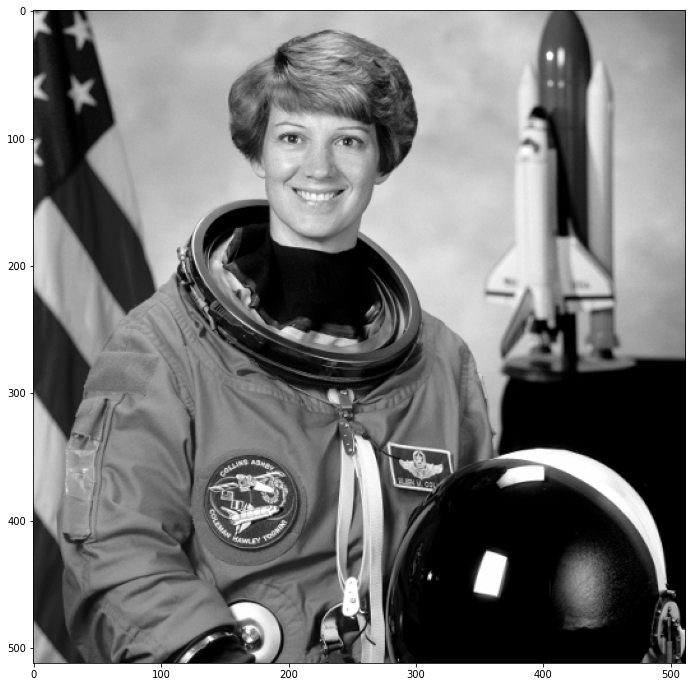

In [5]:
# We use a gray image. All the algorithms should work with color images too.
img = rgb2gray(astronaut() / 255.)
plt.imshow(img, cmap='gray')
plt.show()

In [6]:
def derive_y(image):
    """Computes the derivative of the image w.r.t the y coordinate"""
    derived_image = np.zeros_like(image)
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            if y + 1 < image.shape[1] and y - 1 > 0:
                derived_image[x,y] = (image[x, y + 1] - image[x, y - 1]) / 2.0
    return derived_image

def derive_x(image):
    """Computes the derivative of the image w.r.t the x coordinate"""
    derived_image = np.zeros_like(image)
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            if x + 1 < image.shape[1] and x - 1 > 0:
                derived_image[x,y] = (image[x + 1, y] - image[x - 1, y]) / 2.0
    return derived_image

In [7]:
dx_img = derive_x(img)
dy_img = derive_y(img)

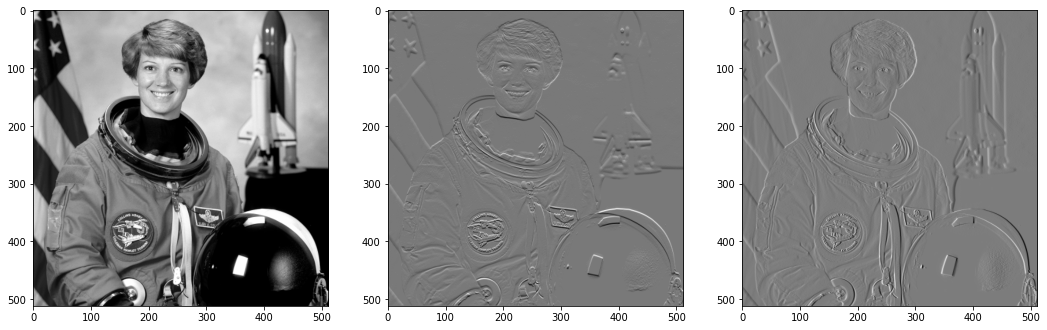

In [8]:
plt.figure(figsize=(18, 12))
plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.subplot(132)
plt.imshow(dx_img, cmap='gray')
plt.subplot(133)
plt.imshow(dy_img, cmap='gray')
plt.show()

Here are some sample affine transformations to be used later on

In [9]:
T_scale = np.array([
    [0.75, 0, 0],
    [0, 0.75, 0],
    [0, 0, 1],
])

In [10]:
T_affine = np.array([
    [1, 0.3, 0],
    [0, 1, 0],
    [0, 0, 1],
])

In [11]:
# you can use this function to invert the matricies
np.linalg.inv(T_scale)

array([[1.33333333, 0.        , 0.        ],
       [0.        , 1.33333333, 0.        ],
       [0.        , 0.        , 1.        ]])

In [367]:
import math

def affine_transformation(img, matrix):
    # note: matrix is a transformation matrix
    # catch the scaling factor
    # Python's math module contain handy functions like floor & ceil. 
    # These functions take a floating point number and return the nearest integer below or above it.
    
    s = img.shape
    # save 4 corners of the original image in homogeneous coordinates 
    # we want to find the new borders based on the transformed 4 corners
    corners = np.array([[0, 0, 1], [0, s[1], 1], [s[0], 0, 1], [s[0], s[1], 1]]).T
    
    # map affine transformation with original corners
    new_corners = matrix @ corners
    # find the maximal corner of the new transformed image
    m = np.ceil(np.max(new_corners, axis=1)).astype(np.int)[:2]
    
    inv_m = np.linalg.inv(matrix)
    
    # build a list of vectors representing every point in the new image
    # np.indices(m) returns an array wih the cootdinates of every point of the image
    # reshape(2, -1) reshapes the returned array into the row vector
    vecs = np.indices(m).reshape(2, -1)
    # np.vstack adds row of "1" a third dimension to perform transromation using homogeneous coordinates
    vecs = np.vstack((vecs, np.ones(vecs.shape[1])))
    # matrix multiplication: map points from the new inage to the original and remove homogeneous component
    vecs = (inv_m@vecs)[:2, :]
    # row vector is converted to the form of 2 D matrix of the same size as new image, where every cell contains 
    # coordinates mapped to the original image
    # Other words: it maps every pixel in the position on the original image
    vecs = vecs.T.reshape(m[0], m[1], -1)
    # apply bicubic interpolation
    return bicubic_interpolation(img, vecs)

In [400]:
def interpolated_intensity(x, y, alpha):
    xs = [1, x, x**2, x**3]
    ys = [1, y, y**2, y**3]

    return sum(alpha[i*4+j]*xs[i]*ys[j] for i in range(4) for j in range(4))


def bicubic_interpolation(img, indicies):
    dx_img = derive_x(img)
    dy_img = derive_y(img)
    dxy_img = derive_x(dy_img)
    # your code here
    o_height, o_width = img.shape
    height, width, _ = indicies.shape
    res = np.zeros((height, width), dtype=np.float)
    
    A_inv = np.array([
        [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [-3,  3,  0,  0, -2, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 2, -2,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0, -3,  3,  0,  0, -2, -1,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  2, -2,  0,  0,  1,  1,  0,  0],
        [-3,  0,  3,  0,  0,  0,  0,  0, -2,  0, -1,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0, -3,  0,  3,  0,  0,  0,  0,  0, -2,  0, -1,  0],
        [ 9, -9, -9,  9,  6,  3, -6, -3,  6, -6,  3, -3,  4,  2,  2,  1],
        [-6,  6,  6, -6, -3, -3,  3,  3, -4,  4, -2,  2, -2, -2, -1, -1],
        [ 2,  0, -2,  0,  0,  0,  0,  0,  1,  0,  1,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  2,  0, -2,  0,  0,  0,  0,  0,  1,  0,  1,  0],
        [-6,  6,  6, -6, -4, -2,  4,  2, -3,  3, -3,  3, -2, -1, -2, -1],
        [ 4, -4, -4,  4,  2,  2, -2, -2,  2, -2,  2, -2,  1,  1,  1,  1]
    ])

    fs = np.floor(indicies).astype(np.int)
    cs = np.ceil(indicies).astype(np.int)
 
    for y in range(height):
        for x in range(width):
            py, px = indicies[y, x]
            fy, fx = fs[y, x]
            cy, cx = cs[y, x]

            if fy < 0 or fy >= o_height or fx < 0 or fx >= o_width \
                or cy < 0 or cy >= o_height or cx < 0 or cx >= o_height:
                continue                    

#             x = [ f (0,0) f (1,0) f (0,1) f (1,1) 
#                      fx (0,0) fx (1,0) fx (0,1) fx (1,1)
#                      fy (0,0) fy (1,0) fy (0,1) fy (1,1) 
#                      fxy (0,0) fxy (1,0) fxy (0,1) fxy (1,1) ]T
        
            coeffs = np.array([
                img[fy, fx], img[cy, fx], img[fy, cx], img[cy, cx],
                dx_img[fy, fx], dx_img[cy, fx], dx_img[fy, cx], dx_img[cy, cx],
                dy_img[fy, fx], dy_img[cy, fx], dy_img[fy, cx], dy_img[cy, cx],
                dxy_img[fy, fx], dxy_img[cy, fx], dxy_img[fy, cx], dxy_img[cy, cx]             
            ])
        
            alpha = A_inv@coeffs
            res[y, x] = interpolated_intensity(px-fx, py-fy, alpha)

    return res


In [401]:
img_scale = affine_transformation(img, T_scale)
img_affine = affine_transformation(img, T_affine)

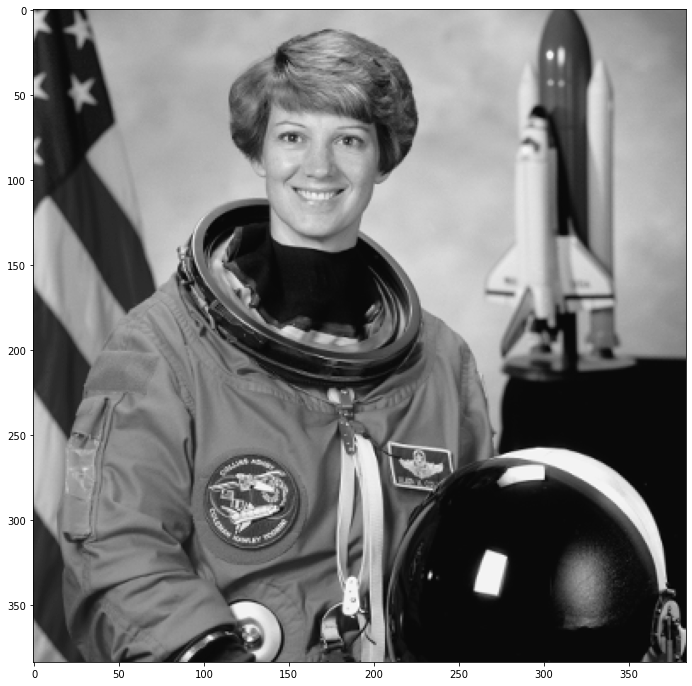

In [402]:
plt.imshow(img_scale, cmap='gray')
plt.show()

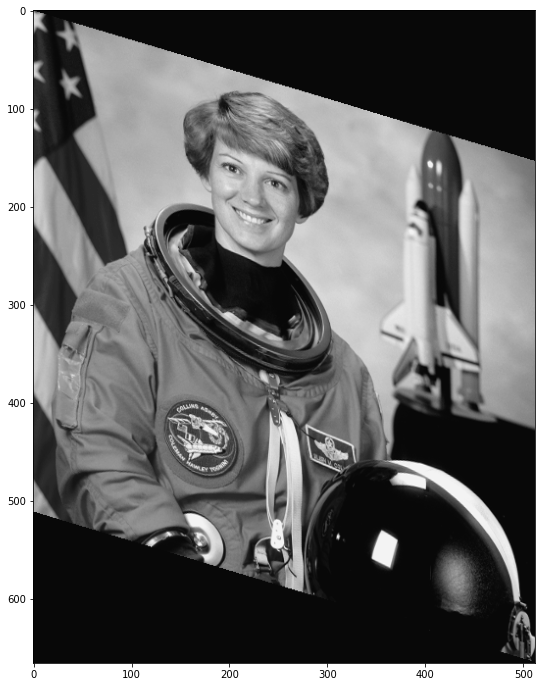

In [403]:
plt.imshow(img_affine, cmap='gray')
plt.show()
